# Regression Part A: Regularized Linear Regression

### Target Variable
- **sbp** (systolic blood pressure): A continuous variable representing the maximum arterial pressure during heart contraction. This is our regression target.

### Features
We use the following features to predict sbp:
- **ldl**: Low-density lipoprotein cholesterol
- **adiposity**: Adiposity measure
- **obesity**: Obesity measure
- **typea**: Type A behavior score
- **age**: Age of the patient
- **tobacco**: Cumulative tobacco consumption (log-transformed)
- **alcohol**: Current alcohol consumption (log-transformed)
- **famhist**: Family history of coronary heart disease (binary: Present=1, Absent=0)
- **chd**: Coronary heart disease (binary indicator)

### Feature Transformations

To prepare the data for regularized linear regression, we apply the following transformations:

1. **Standardization**: Each feature is standardized to have mean = 0 and standard deviation = 1. This is essential for regularization, as it ensures that the regularization penalty affects all features equally regardless of their original scale.

2. **Log transformation**: The `tobacco` and `alcohol` features are log-transformed using `log1p` (log(1+x)) to handle their skewed distributions.

3. **Binary encoding**: The categorical feature `famhist` is encoded as binary (Present=1, Absent=0).

### Goal
The goal is to predict systolic blood pressure to assess cardiovascular risk. By understanding which factors contribute most to elevated blood pressure, we can better identify patients at risk and inform preventive interventions.

In [51]:
# load and transform the data
import pandas as pd
df_heart = pd.read_csv(
    "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)
columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]
missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]

In [52]:
import numpy as np

# binary transformation of categorical attribute needed
df_heart['famhist'] = df_heart['famhist'].map({'Present': 1, 'Absent': 0})

# log transform skewed columns as described in part 1:
columns_to_log_transform = ['tobacco','alcohol']
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

# center the data to have mean = 0 and variance = 1
# manual scalation of the data returns very slightly different values due to float representation:
df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

df_heart_standarized.head()

,sbp,ldl,adiposity,obesity,typea,age,tobacco,alcohol,famhist,chd
row.names,,,,,,,,,,
1,1.057417,0.477894,-0.295183,-0.176594,-0.418017,0.628654,1.576878,1.772852,1,1.372375
2,0.276789,-0.159507,0.411694,0.670646,0.193134,1.381617,-1.193044,-0.563821,0,1.372375
3,-0.991731,-0.608585,0.883374,0.734723,-0.112441,0.217947,-1.120397,-0.259134,1,-0.727086
4,1.545310,0.806252,1.622382,1.411091,-0.214300,1.039361,1.116254,0.858159,1,1.372375
5,-0.211103,-0.598928,0.305020,-0.012842,0.702427,0.423301,1.702714,1.422062,1,1.372375


## 1. Regularization Parameter Tuning

We begin by examining the most elementary model, namely **linear regression**. We use **Ridge regression** (L₂ regularized linear regression), which is a unified framework that includes both ordinary linear regression and regularized linear regression:

- **When λ = 0**: Ridge regression reduces to **ordinary least squares (OLS) linear regression** - the elementary model with no regularization. This is the basic linear regression model.
- **When λ > 0**: Ridge regression applies L₂ regularization, shrinking coefficients toward zero to reduce overfitting.

The regularization parameter λ controls the trade-off between bias and variance:
- **λ = 0 (OLS)**: Low bias, high variance (may overfit) - this is the elementary linear regression model
- **Small λ**: Low bias, high variance (may overfit)
- **Optimal λ***: Best balance between bias and variance, minimizing generalization error
- **Large λ**: High bias, low variance (may underfit)

We will use **10-fold cross-validation** (Algorithm 5) to estimate the generalization error for different values of λ. We choose a range of λ values (ideally one where the generalization error first drops and then increases) to observe the characteristic U-shaped curve. The optimal λ* is selected as the value that minimizes the estimated generalization error.

We will perform this analysis using:
1. **All features** (9 features) - primary analysis for Part A
2. **PCA-transformed features** (6 principal components, capturing >90% of variance) - supplementary analysis

We use **sklearn's Ridge** implementation, which efficiently handles both λ=0 (OLS) and λ>0 (regularized) cases. This is equivalent to using `LinearRegression` when λ=0, but using Ridge allows us to smoothly vary the regularization parameter.


In [53]:
# Prepare data for regression
# Separate features (X) and target (y)
X = df_heart_standarized.drop(columns=["sbp"])
y = df_heart_standarized["sbp"]

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Features: {df_heart_standarized.drop(columns=['sbp']).columns.tolist()}")

# Create PCA-transformed features (6 components for >90% variance)
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(X)
X_pca = pca.transform(X)

print(f"\nPCA-transformed data shape: X_pca={X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")


Data shape: X=(462, 9), y=(462,)
Features: ['ldl', 'adiposity', 'obesity', 'typea', 'age', 'tobacco', 'alcohol', 'famhist', 'chd']

PCA-transformed data shape: X_pca=(462, 6)
Explained variance ratio: [0.35002307 0.14602647 0.1304005  0.11989867 0.08128627 0.07431883]
Total explained variance: 0.9020


In [54]:
# Implement Algorithm 5: K-fold cross-validation for model selection using sklearn
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Choose a range of λ values (regularization parameter)
lambda_values = np.concatenate([[0.0], np.logspace(-4, 4, 200)])

# Set up 10-fold cross-validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results for each λ (all features)
results_all = {
    'lambda': [],
    'mean_mse': [],
    'std_mse': [],
    'fold_mses': []
}

# Store results for each λ (PCA features)
results_pca = {
    'lambda': [],
    'mean_mse': [],
    'std_mse': [],
    'fold_mses': []
}

In [55]:
print(f"Testing {len(lambda_values)} lambda values with {k_folds}-fold cross-validation...")
print(f"Lambda range: [{lambda_values[0]:.6f}, {lambda_values[-1]:.6f}]\n")

# For each λ value, perform cross-validation on all features
for i, lam in enumerate(lambda_values):
    fold_mses = []
    
    #  K-fold cross-validation
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = Ridge(alpha=lam, fit_intercept=True)
        model.fit(X_train, y_train)
        
        # pred on test set
        y_pred = model.predict(X_test)
        
        # compute MSE for this fold
        mse = mean_squared_error(y_test, y_pred)
        fold_mses.append(mse)
    
    # comp mean and std of MSE across folds
    mean_mse = np.mean(fold_mses)
    std_mse = np.std(fold_mses)
    
    results_all['lambda'].append(lam)
    results_all['mean_mse'].append(mean_mse)
    results_all['std_mse'].append(std_mse)
    results_all['fold_mses'].append(fold_mses)
    
    if (i + 1) % 100 == 0 or i == 0:
        print(f"λ = {lam:.6f}: Mean MSE = {mean_mse:.6f} ± {std_mse:.6f}")

print("\nCross-validation complete for all features!")

Testing 201 lambda values with 10-fold cross-validation...
Lambda range: [0.000000, 10000.000000]

λ = 0.000000: Mean MSE = 0.848815 ± 0.170540
λ = 0.870359: Mean MSE = 0.848647 ± 0.170456
λ = 9115.888300: Mean MSE = 0.970794 ± 0.200445

Cross-validation complete for all features!


In [56]:

print("CROSS-VALIDATION WITH PCA FEATURES (6 components)")
print(f"Testing {len(lambda_values)} lambda values with {k_folds}-fold cross-validation...")
print(f"Lambda range: [{lambda_values[0]:.6f}, {lambda_values[-1]:.6f}]\n")

for i, lam in enumerate(lambda_values):
    fold_mses = []
    
    # K-fold cross-validation
    for train_idx, test_idx in kf.split(X_pca):
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = Ridge(alpha=lam, fit_intercept=True)
        model.fit(X_train, y_train)
        
        # pred on test set
        y_pred = model.predict(X_test)
        
        # MSE for this fold
        mse = mean_squared_error(y_test, y_pred)
        fold_mses.append(mse)
    
    # compute mean and std of MSE across folds
    mean_mse = np.mean(fold_mses)
    std_mse = np.std(fold_mses)
    
    results_pca['lambda'].append(lam)
    results_pca['mean_mse'].append(mean_mse)
    results_pca['std_mse'].append(std_mse)
    results_pca['fold_mses'].append(fold_mses)
    
    if (i + 1) % 100 == 0 or i == 0:
        print(f"λ = {lam:.6f}: Mean MSE = {mean_mse:.6f} ± {std_mse:.6f}")

print("\nCross-validation complete for PCA features!")


CROSS-VALIDATION WITH PCA FEATURES (6 components)
Testing 201 lambda values with 10-fold cross-validation...
Lambda range: [0.000000, 10000.000000]

λ = 0.000000: Mean MSE = 0.852164 ± 0.170126
λ = 0.870359: Mean MSE = 0.852108 ± 0.170097
λ = 9115.888300: Mean MSE = 0.971141 ± 0.200379

Cross-validation complete for PCA features!


In [57]:
# Find optimal λ for all features
optimal_idx_all = np.argmin(results_all['mean_mse'])
optimal_lambda_all = results_all['lambda'][optimal_idx_all]
optimal_mse_all = results_all['mean_mse'][optimal_idx_all]
optimal_std_all = results_all['std_mse'][optimal_idx_all]


In [58]:
# Find optimal λ for PCA features
optimal_idx_pca = np.argmin(results_pca['mean_mse'])
optimal_lambda_pca = results_pca['lambda'][optimal_idx_pca]
optimal_mse_pca = results_pca['mean_mse'][optimal_idx_pca]
optimal_std_pca = results_pca['std_mse'][optimal_idx_pca]

In [59]:
print("OPTIMAL REGULARIZATION PARAMETERS")
print(f"\nAll Features:")
print(f"\tOptimal λ* = {optimal_lambda_all:.6f}")
print(f"\tOptimal Mean MSE = {optimal_mse_all:.6f} ± {optimal_std_all:.6f}")

print(f"\nPCA Features (6 components):")
print(f"  Optimal λ* = {optimal_lambda_pca:.6f}")
print(f"  Optimal Mean MSE = {optimal_mse_pca:.6f} ± {optimal_std_pca:.6f}")

OPTIMAL REGULARIZATION PARAMETERS

All Features:
	Optimal λ* = 107.189132
	Optimal Mean MSE = 0.842353 ± 0.168302

PCA Features (6 components):
  Optimal λ* = 117.584955
  Optimal Mean MSE = 0.849038 ± 0.169063


In [60]:
# results DataFrames for easier inspection
results_df_all = pd.DataFrame({
    'lambda': results_all['lambda'],
    'mean_mse': results_all['mean_mse'],
    'std_mse': results_all['std_mse']
})

results_df_pca = pd.DataFrame({
    'lambda': results_pca['lambda'],
    'mean_mse': results_pca['mean_mse'],
    'std_mse': results_pca['std_mse']
})

In [61]:
print("Results around optimal λ (All Features):")
optimal_range_all = results_df_all.iloc[max(0, optimal_idx_all-2):min(len(results_df_all), optimal_idx_all+3)]
print(optimal_range_all.to_string(index=False))

Results around optimal λ (All Features):
    lambda  mean_mse  std_mse
 89.073546  0.842472 0.168199
 97.712415  0.842391 0.168238
107.189132  0.842353 0.168302
117.584955  0.842363 0.168392
128.989026  0.842428 0.168512


In [62]:
print("Results around optimal λ (PCA Features):")
optimal_range_pca = results_df_pca.iloc[max(0, optimal_idx_pca-2):min(len(results_df_pca), optimal_idx_pca+3)]
print(optimal_range_pca.to_string(index=False))

Results around optimal λ (PCA Features):
    lambda  mean_mse  std_mse
 97.712415  0.849111 0.168973
107.189132  0.849060 0.169008
117.584955  0.849038 0.169063
128.989026  0.849051 0.169142
141.499130  0.849107 0.169248


In [63]:
# Use all features results as primary (for backward compatibility)
results = results_all
optimal_lambda = optimal_lambda_all
optimal_mse = optimal_mse_all
optimal_std = optimal_std_all
optimal_idx = optimal_idx_all


## 2. Visualization: Generalization Error vs Regularization Parameter

We plot the estimated generalization error (MSE) as a function of the regularization parameter λ. The optimal λ* is marked on the plot.


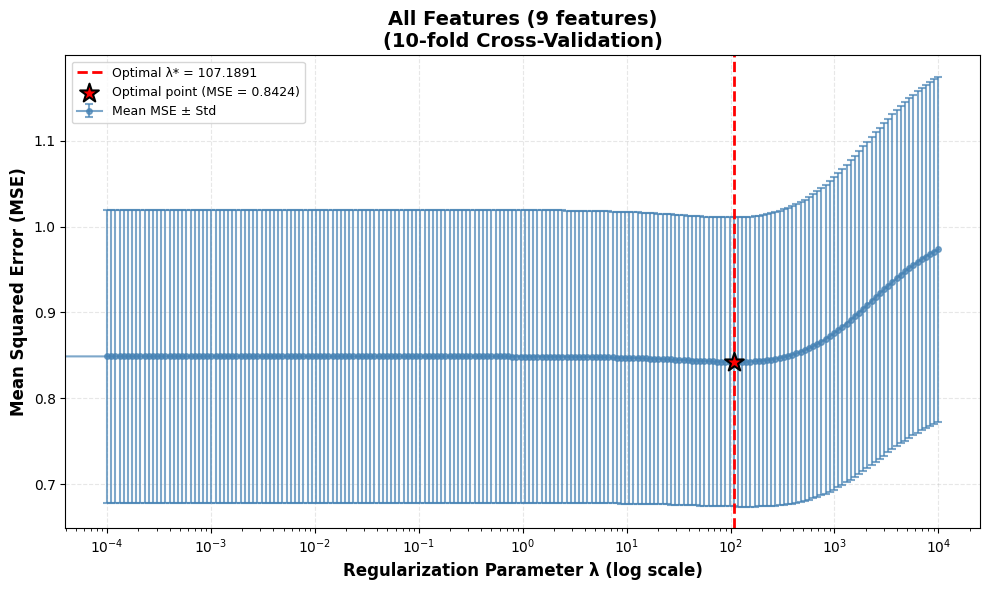

All Features - Optimal λ* = 107.189132 with MSE = 0.842353 ± 0.168302


In [64]:
# Visualization 1: MSE vs λ for All Features
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(results_all['lambda'], results_all['mean_mse'], 
             yerr=results_all['std_mse'], 
             fmt='o-', 
             markersize=4,
             capsize=3,
             capthick=1.5,
             elinewidth=1.5,
             label='Mean MSE ± Std',
             color='steelblue',
             alpha=0.7)

# Mark optimal λ* with a vertical line
ax.axvline(x=optimal_lambda_all, 
            color='red', 
            linestyle='--', 
            linewidth=2,
            label=f'Optimal λ* = {optimal_lambda_all:.4f}')

# Mark optimal point
ax.scatter([optimal_lambda_all], [optimal_mse_all], 
           color='red', 
           s=200, 
           zorder=5,
           marker='*',
           edgecolors='black',
           linewidths=1.5,
           label=f'Optimal point (MSE = {optimal_mse_all:.4f})')

ax.set_xscale('log')
ax.set_xlabel('Regularization Parameter λ (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
ax.set_title('All Features (9 features)\n(10-fold Cross-Validation)', 
              fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=9, loc='best')

plt.tight_layout()
plt.show()

print(f"All Features - Optimal λ* = {optimal_lambda_all:.6f} with MSE = {optimal_mse_all:.6f} ± {optimal_std_all:.6f}")


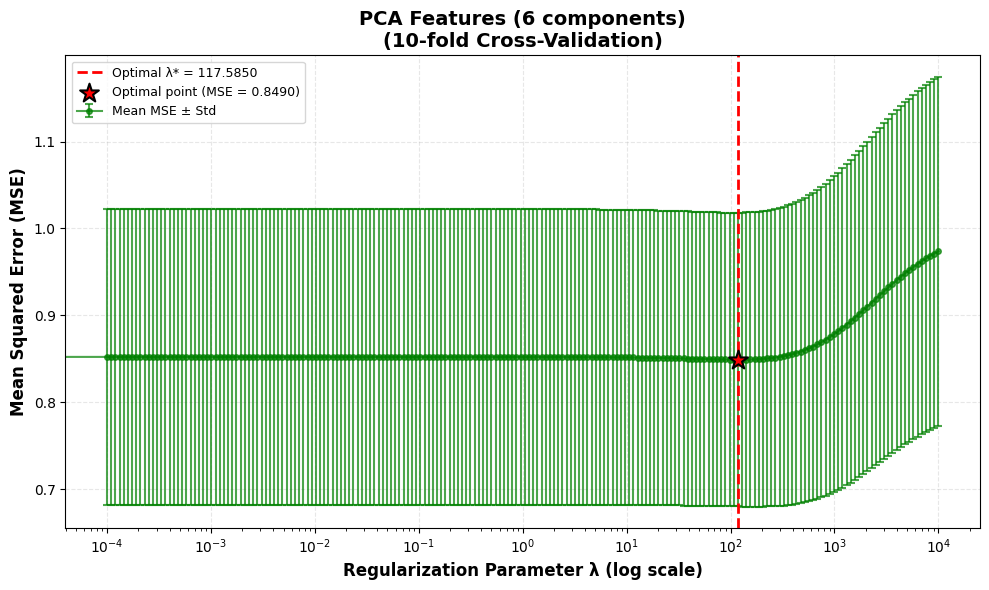

PCA Features - Optimal λ* = 117.584955 with MSE = 0.849038 ± 0.169063


In [65]:
# Visualization 2: MSE vs λ for PCA Features
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(results_pca['lambda'], results_pca['mean_mse'], 
             yerr=results_pca['std_mse'], 
             fmt='o-', 
             markersize=4,
             capsize=3,
             capthick=1.5,
             elinewidth=1.5,
             label='Mean MSE ± Std',
             color='green',
             alpha=0.7)

# Mark optimal λ* with a vertical line
ax.axvline(x=optimal_lambda_pca, 
            color='red', 
            linestyle='--', 
            linewidth=2,
            label=f'Optimal λ* = {optimal_lambda_pca:.4f}')

# Mark optimal point
ax.scatter([optimal_lambda_pca], [optimal_mse_pca], 
           color='red', 
           s=200, 
           zorder=5,
           marker='*',
           edgecolors='black',
           linewidths=1.5,
           label=f'Optimal point (MSE = {optimal_mse_pca:.4f})')

ax.set_xscale('log')
ax.set_xlabel('Regularization Parameter λ (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
ax.set_title('PCA Features (6 components)\n(10-fold Cross-Validation)', 
              fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=9, loc='best')

plt.tight_layout()
plt.show()

print(f"PCA Features - Optimal λ* = {optimal_lambda_pca:.6f} with MSE = {optimal_mse_pca:.6f} ± {optimal_std_pca:.6f}")


## 3. Train Final Model with Optimal λ*

Now we train the final Ridge regression model using the optimal regularization parameter λ* on all available data. This model will be used for interpretation and prediction.


In [66]:
# training final model on all data with optimal λ*. We focus on the all-features model
print(f'Trainig the final model on all data with optimal λ* = {optimal_lambda_all:.6f}')
final_model_all = Ridge(alpha=optimal_lambda_all, fit_intercept=True)
final_model_all.fit(X, y)

Trainig the final model on all data with optimal λ* = 107.189132


,alpha,np.float64(107.18913192051286)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [67]:
# extract coefficients and intercept
coefficients_all = final_model_all.coef_.flatten()
intercept_all = final_model_all.intercept_

# feature names
feature_names = df_heart_standarized.drop(columns=['sbp']).columns.tolist()

# coefficient DataFrame for all features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_all
})

coef_df

,Feature,Coefficient
0,ldl,0.003598
1,adiposity,0.124782
2,obesity,0.062093
3,typea,-0.035444
4,age,0.202545
5,tobacco,0.009347
6,alcohol,0.089758
7,famhist,-0.017142
8,chd,0.060741


In [68]:
# sort by absolute coefficient value (importance)
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

In [69]:
print("FINAL MODEL SUMMARY - ALL FEATURES")
print(f"Intercept (w₀): {intercept_all:.6f}")
print(f"Regularization parameter λ*: {optimal_lambda_all:.6f}")
print(f"Optimal Mean MSE (from CV): {optimal_mse_all:.6f} ± {optimal_std_all:.6f}")
print("\nCoefficients (sorted by absolute value):")
print(coef_df.to_string(index=False))

print(f"\nModel trained successfully on all {len(y)} samples.")


FINAL MODEL SUMMARY - ALL FEATURES
Intercept (w₀): 0.007124
Regularization parameter λ*: 107.189132
Optimal Mean MSE (from CV): 0.842353 ± 0.168302

Coefficients (sorted by absolute value):
  Feature  Coefficient  Abs_Coefficient
      age     0.202545         0.202545
adiposity     0.124782         0.124782
  alcohol     0.089758         0.089758
  obesity     0.062093         0.062093
      chd     0.060741         0.060741
    typea    -0.035444         0.035444
  famhist    -0.017142         0.017142
  tobacco     0.009347         0.009347
      ldl     0.003598         0.003598

Model trained successfully on all 462 samples.


## 4. Model Interpretation

### How the Output $y$ is Computed for a Given Input $\mathbf{x}$

The linear regression model with optimal regularization parameter λ* computes the output $y$ (systolic blood pressure) for a given input $\mathbf{x}$ using the following formula:

$$y = w_0 + \sum_{i=1}^{M} w_i \cdot \hat{x}_i$$

where:
- $w_0$ is the intercept (bias term), which represents the predicted SBP when all features are at their mean values (since features are standardized)
- $w_i$ are the coefficients (weights) for each feature $i$
- $\hat{x}_i$ are the **standardized** features (mean=0, std=1) - the original features transformed to have zero mean and unit variance
- $M$ is the number of features (9 in our case)

This is the standard linear regression prediction formula. When λ = 0, this corresponds to ordinary least squares (OLS) regression. When λ > 0 (as in our optimal model with λ*), this is Ridge regression, where the coefficients $w_i$ have been regularized (shrunk toward zero) to reduce overfitting.


**Example prediction:** For a patient with standardized feature values $\hat{\mathbf{x}} = [\hat{x}_1, \hat{x}_2, \ldots, \hat{x}_9]$, the predicted SBP is:
$$y = w_0 + w_1 \hat{x}_1 + w_2 \hat{x}_2 + \cdots + w_9 \hat{x}_9$$

### Effect of Individual Attributes on the Output $y$

Since the features are standardized, the coefficients $w_i$ represent the effect of a **one standard deviation increase** in feature $i$ on the systolic blood pressure (in standardized units). This interpretation is valid because:

1. **Standardization ensures comparability**: All features are on the same scale (mean=0, std=1), so coefficients can be directly compared
2. **Linear relationship**: The effect is linear and additive - each feature contributes independently to the prediction
3. **Coefficient interpretation**:
   - **Sign**: 
     - Positive $w_i$: An increase in feature $i$ increases SBP
     - Negative $w_i$: An increase in feature $i$ decreases SBP
   - **Magnitude**: Larger absolute values $|w_i|$ indicate stronger effects on SBP

The regularization (λ* > 0) helps ensure that the coefficients are not overly large due to overfitting, making the model more stable and generalizable.


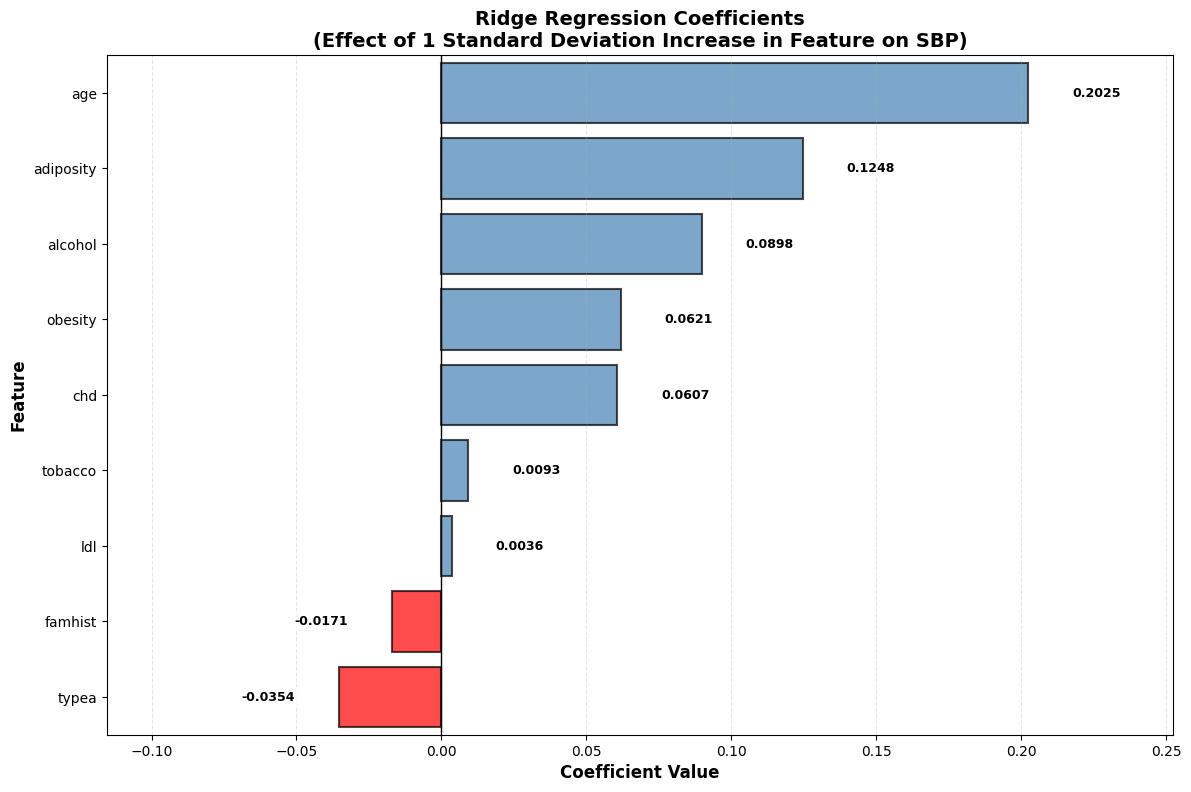

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# sorting
coef_df_sorted = coef_df.sort_values('Coefficient', ascending=True)

colors = ['red' if x < 0 else 'steelblue' for x in coef_df_sorted['Coefficient']]
bars = ax.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# vertical line at zero
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

x_min = coef_df_sorted['Coefficient'].min()
x_max = coef_df_sorted['Coefficient'].max()
ax.set_xlim(left=x_min - 0.08, right=x_max + 0.05)

# Adjust y-axis to add padding
ax.set_ylim(-0.5, len(coef_df_sorted) - 0.5)

ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Ridge Regression Coefficients\n(Effect of 1 Standard Deviation Increase in Feature on SBP)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x', linestyle='--')

# Position coefficient value labels with better spacing and background
for i, (idx, row) in enumerate(coef_df_sorted.iterrows()):
    value = row['Coefficient']
    # For negative values, place text further left; for positive, place further right
    offset = 0.015 if value >= 0 else -0.015
    ax.text(value + offset, i, 
            f'{value:.4f}', 
            va='center', 
            ha='left' if value >= 0 else 'right',
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout(pad=1.0)
plt.show()

In [71]:
# Print detailed interpretation
print("\n" + "="*80)
print("COEFFICIENT INTERPRETATION")
print("="*80)
print("\nPositive coefficients (increase SBP):")
positive_coefs = coef_df[coef_df['Coefficient'] > 0].sort_values('Coefficient', ascending=False)
for _, row in positive_coefs.iterrows():
    print(f"  {row['Feature']:15s}: {row['Coefficient']:8.4f} (1 std increase → +{row['Coefficient']:.4f} std in SBP)")

print("\nNegative coefficients (decrease SBP):")
negative_coefs = coef_df[coef_df['Coefficient'] < 0].sort_values('Coefficient', ascending=True)
for _, row in negative_coefs.iterrows():
    print(f"  {row['Feature']:15s}: {row['Coefficient']:8.4f} (1 std increase → {row['Coefficient']:.4f} std in SBP)")

print("\n" + "="*80)



COEFFICIENT INTERPRETATION

Positive coefficients (increase SBP):
  age            :   0.2025 (1 std increase → +0.2025 std in SBP)
  adiposity      :   0.1248 (1 std increase → +0.1248 std in SBP)
  alcohol        :   0.0898 (1 std increase → +0.0898 std in SBP)
  obesity        :   0.0621 (1 std increase → +0.0621 std in SBP)
  chd            :   0.0607 (1 std increase → +0.0607 std in SBP)
  tobacco        :   0.0093 (1 std increase → +0.0093 std in SBP)
  ldl            :   0.0036 (1 std increase → +0.0036 std in SBP)

Negative coefficients (decrease SBP):
  typea          :  -0.0354 (1 std increase → -0.0354 std in SBP)
  famhist        :  -0.0171 (1 std increase → -0.0171 std in SBP)

